In [1]:
import straw
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
path_save="/Users/ealjibur/OneDrive - Imperial College London/HiC/Hic_ya/"
#parameters 
Range = 10e8
resolution = 5000
no_qs = 5

In [3]:
local_contacts = pd.read_csv("CD69negDPWTR2"+".wig", sep="\t",
                             names=list(["chromosome","start","end","lc_score"]))
local_contacts["lc_bins_1"] = pd.qcut(local_contacts["lc_score"], q=no_qs)

In [307]:
high_contacts = (local_contacts["lc_bins_1"] ==local_contacts["lc_bins_1"].dtype.categories[-1])

local_contacts["lc_bins"] = np.nan
local_contacts.lc_bins[high_contacts] = pd.qcut(local_contacts.lc_score[high_contacts], q=no_qs)

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='lc_score', ylabel='Density'>

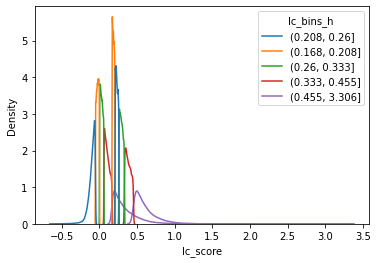

In [275]:
sns.kdeplot(local_contacts["lc_score"], hue=local_contacts["lc_bins"])
sns.kdeplot(local_contacts["lc_score"], hue=local_contacts["lc_bins_h"])

In [310]:
norms={'CD69negDPWTR3': 417830413, 'CD69negDPWTR4': 427257794, 'CD69negDPCTCFKOR1': 424715008,
 'CD69negDPCTCFKOR2': 325929677, 'CD69negDPDKOR1': 158131390, 'CD69negDPDKOR2': 175281770}

In [311]:
All_chroms = pd.DataFrame({"lc_bins":pd.Series([], dtype=local_contacts["lc_bins"].dtype),
                           "Chromosome":pd.Series([], dtype='str'),
                           "distance":pd.Series([], dtype='int'), "file_name": pd.Series([], dtype='str') })

for filename in ["CD69negDPWTR3","CD69negDPWTR4", "CD69negDPCTCFKOR1", "CD69negDPCTCFKOR2", "CD69negDPDKOR1", "CD69negDPDKOR2"]:
    path_to_hic=path_save+filename+".hic"

    #initialising Hi-C file ad chromosome dictionary.
    HiC_Matrix = straw.straw(path_to_hic)
    chrDict = HiC_Matrix.chromDotSizes.data
    chrDict.pop("All")
    chrDict.pop("chrM")
    chrDict.pop("chrY")
    chrDict.pop("chrX")

    for chromosome in chrDict.keys():
        #get chromosome information from HiC
        norm_hic= HiC_Matrix.getNormalizedMatrix(chromosome,chromosome, "KR", "BP",resolution)
        xpos, ypos, vals = norm_hic.getDataFromGenomeRegion(0,chrDict[chromosome][1], 0,chrDict[chromosome][1])
        curr = pd.DataFrame({"x":xpos, "y": ypos, "values": vals}) 
        
        curr["distance"] = np.abs(curr.x-curr.y)*resolution 
        curr["values"] = curr["values"]/norms[filename]
        curr = pd.melt(curr, id_vars=['values','distance'], value_vars=['x','y'])
        
        
        curr["start"]=curr["value"]*resolution+1
        curr = curr.merge(local_contacts[local_contacts["chromosome"]==chromosome][["start", "lc_bins"]], 
                how="left", on="start").copy()

        curr=curr.groupby(["lc_bins","distance"]).sum()
        curr.reset_index(inplace=True) 
        curr.drop(columns=["value", "start"], inplace=True)

        #clean matrix
        curr["Chromosome"]=chromosome
        curr["file_name"]=filename

        #add to pandasas array containing full list 
        All_chroms = All_chroms.append(curr, ignore_index=True)

HiC version:  8
HiC version:  8
HiC version:  8
HiC version:  8
HiC version:  8
HiC version:  8


In [312]:
distribution = All_chroms.groupby(["file_name","lc_bins", "distance"],as_index=False).sum()
distribution = distribution[(distribution.distance>1000) & (distribution.distance<58175000)]

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


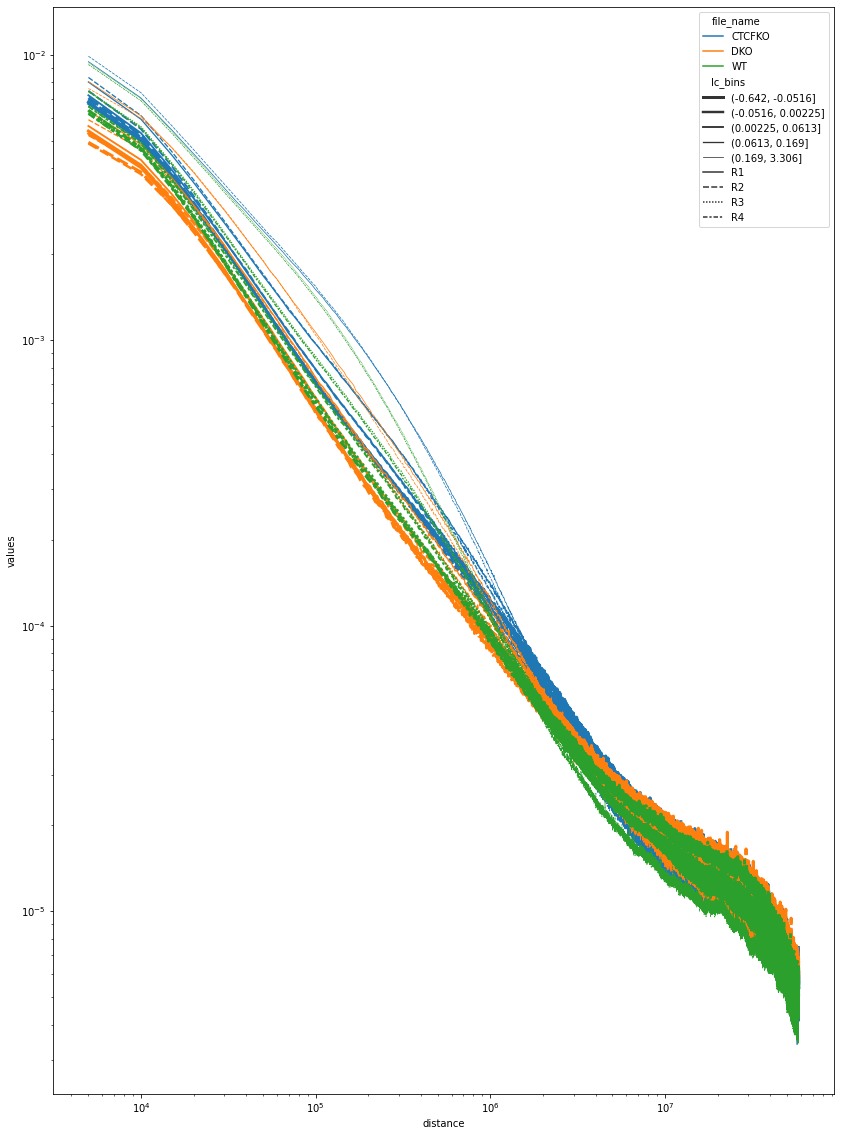

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


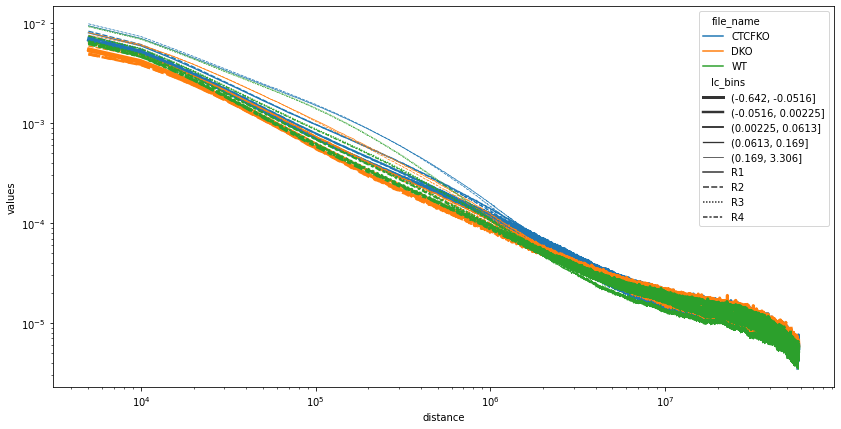

In [295]:
f, ax = plt.subplots(figsize=( 14, 20))
sns.lineplot(distribution["distance"],
             distribution["values"], 
             ax = ax, 
             hue = distribution["file_name"].str[9:-2], 
             style = distribution["file_name"].str[-2:], 
             size = distribution["lc_bins"])
ax.set(xscale = "log", yscale = "log")
plt.show()

f, ax = plt.subplots(figsize=( 14, 7))
sns.lineplot(distribution["distance"],
             distribution["values"], 
             ax=ax, 
             hue=distribution["file_name"].str[9:-2], 
             style =distribution["file_name"].str[-2:], 
             size = distribution["lc_bins"] )
#ax.set(xlim=(10e3, 10e5))
ax.set(xscale="log", yscale="log")
plt.show()

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


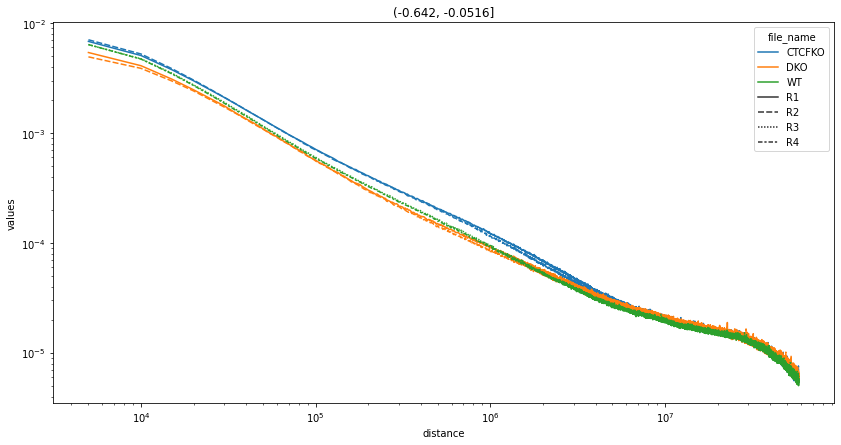

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


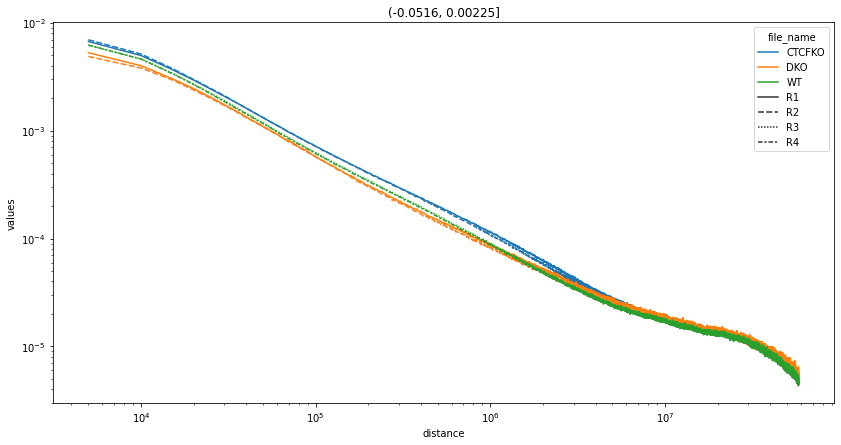

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


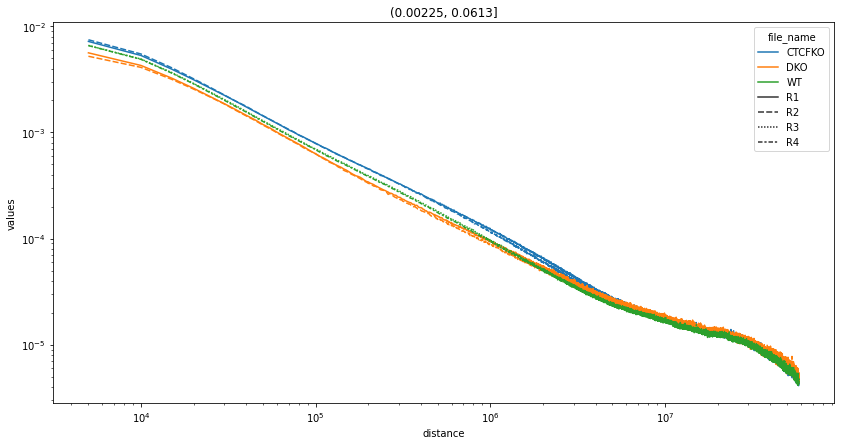

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


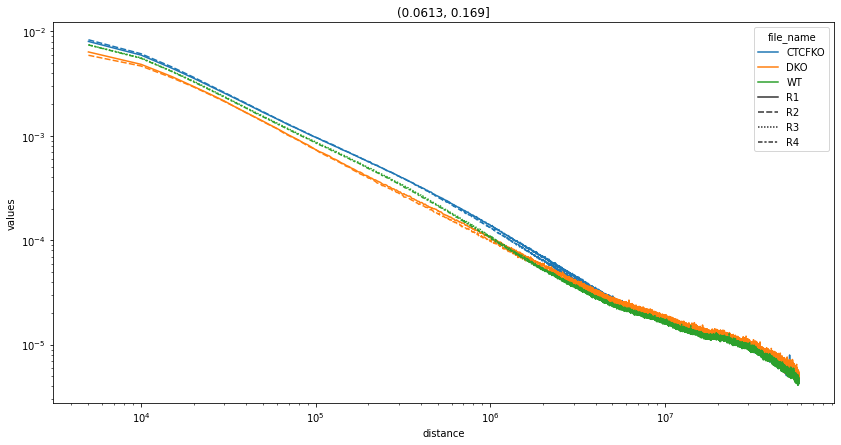

/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


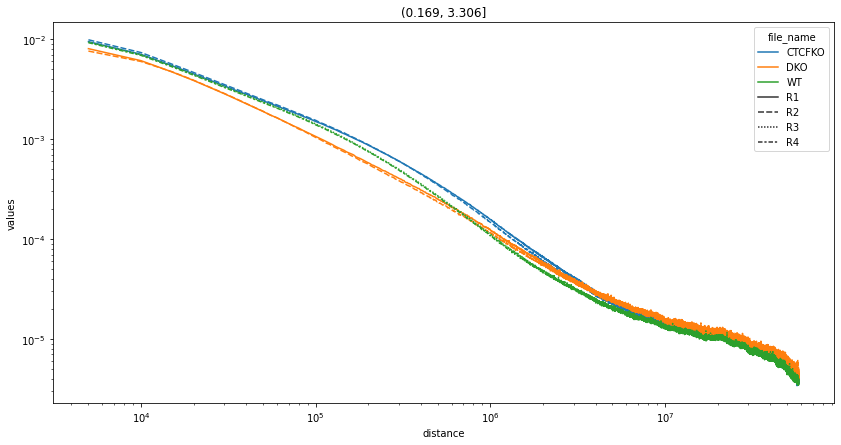

In [296]:
for lc in distribution["lc_bins"].unique():
    d1 =distribution[distribution["lc_bins"] == lc ] 
    f, ax = plt.subplots(figsize=( 14, 7))
    sns.lineplot(d1["distance"],
                 d1["values"], 
                 ax=ax, 
                 hue=d1["file_name"].str[9:-2], 
                 style =d1["file_name"].str[-2:] )
    ax.set_title(lc)
    #ax.set(xlim=(10e3, 10e5))
    ax.set(xscale="log", yscale="log")
    plt.show()

In [314]:
for_diff_plots = distribution.pivot(index=["lc_bins", "distance"], columns="file_name", values='values').reset_index()


/Users/ealjibur/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(1000.0, 10000000.0)]

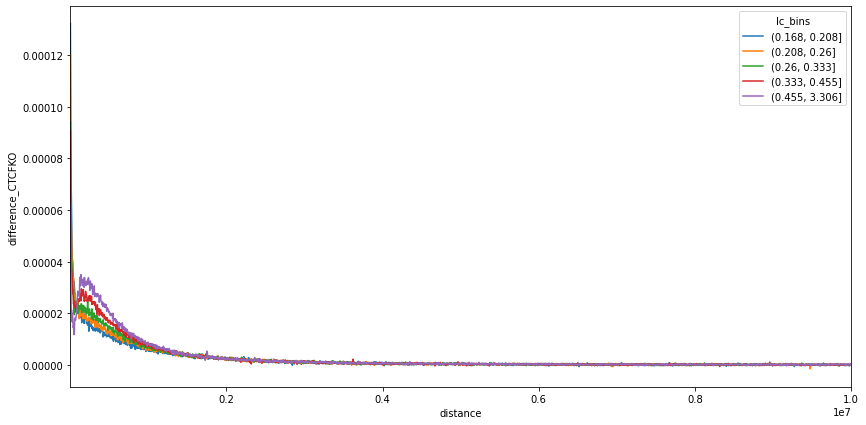

In [320]:
for_diff_plots["difference_CTCFKO"] = for_diff_plots["CD69negDPCTCFKOR2"]-for_diff_plots["CD69negDPWTR3"]
f, ax = plt.subplots(figsize=( 14, 7))
sns.lineplot(for_diff_plots.distance, for_diff_plots.difference_CTCFKO, hue=for_diff_plots.lc_bins, ax= ax)
ax.set(xlim=(10e2, 10e6))